In [11]:
import json
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

file_path = "../../data/letterboxd_filtered_llm2_filtered.jsonl"

try:
    df = pl.read_ndjson(file_path, ignore_errors=True)
    print("Successfully loaded!")
    print(f"Memory size: {df.estimated_size('mb'):.2f} MB\n")
except Exception as e:
    print(f"Error loading file: {e}\n")
    exit(1)

num_films = 0
num_synopses = 0
num_reviews = 0

synopsis_chars = 0
review_chars = 0

with open(file_path, encoding="utf-8") as f:
    for line in f:
        num_films += 1
        data = json.loads(line)

        synopsis = data.get("synopsis", "")
        if synopsis:
            num_synopses += 1
            synopsis_chars += len(synopsis)

        reviews = data.get("review_texts", [])
        num_reviews += len(reviews)
        for r in reviews:
            review_chars += len(r)

total_chars = synopsis_chars + review_chars

print("Films:", num_films)
print("Synopses:", num_synopses)
print("Reviews:", num_reviews)
print("Synopsis characters:", synopsis_chars)
print("Review characters:", review_chars)
print("Total characters:", total_chars)

Successfully loaded!
Memory size: 167.13 MB

Films: 212944
Synopses: 212944
Reviews: 533625
Synopsis characters: 76102469
Review characters: 92333461
Total characters: 168435930


In [12]:
df_null_values = df.filter(pl.col("synopsis").is_null()).select("title").unique()

print(f"Number of different movies with NULL synopsis: {len(df_null_values)}")
# print(df_null_values.head(10))

short_synopsis = (
    df.filter(pl.col("synopsis").is_not_null() & (pl.col("synopsis").str.split(" ").list.len() <= 10))
    .select(["title", "synopsis", "review_texts"])
    .unique(subset=["title"])
)

print(f"Movies with short synopses: {len(short_synopsis)}")
for row in short_synopsis.head().iter_rows(named=True):
    print(f"\nTitle: {row['title']}")
    print(f"Synopsis: {row['synopsis']}")
    print("-" * 80)

Number of different movies with NULL synopsis: 0
Movies with short synopses: 6870

Title: Gnoo Zoo - in Search of the Great White Tiger
Synopsis: Based on the Book by: Sheila Walsh
--------------------------------------------------------------------------------

Title: Christopher Lee: Gentleman of Horror
Synopsis: A documentary directed by Oliver Schwehm.
--------------------------------------------------------------------------------

Title: Belfast : Queen's Bridge
Synopsis: Another critically acclaimed Lumiere street scene.
--------------------------------------------------------------------------------

Title: GOBY
Synopsis: A short film by Matthew Cutchen.
--------------------------------------------------------------------------------

Title: Love Live! Superstar!! Liella! First LoveLive! Tour 〜Starlines〜
Synopsis: Liella!'s first solo live concert.
--------------------------------------------------------------------------------



synopsis:
shape: (1, 6)
┌─────┬──────┬───────────┬───────────┬──────────┬────────┐
│ min ┆ max  ┆ mean      ┆ std_dev   ┆ total    ┆ median │
│ --- ┆ ---  ┆ ---       ┆ ---       ┆ ---      ┆ ---    │
│ u32 ┆ u32  ┆ f64       ┆ f64       ┆ u32      ┆ f64    │
╞═════╪══════╪═══════════╪═══════════╪══════════╪════════╡
│ 1   ┆ 2237 ┆ 60.759317 ┆ 52.587701 ┆ 12938332 ┆ 47.0   │
└─────┴──────┴───────────┴───────────┴──────────┴────────┘


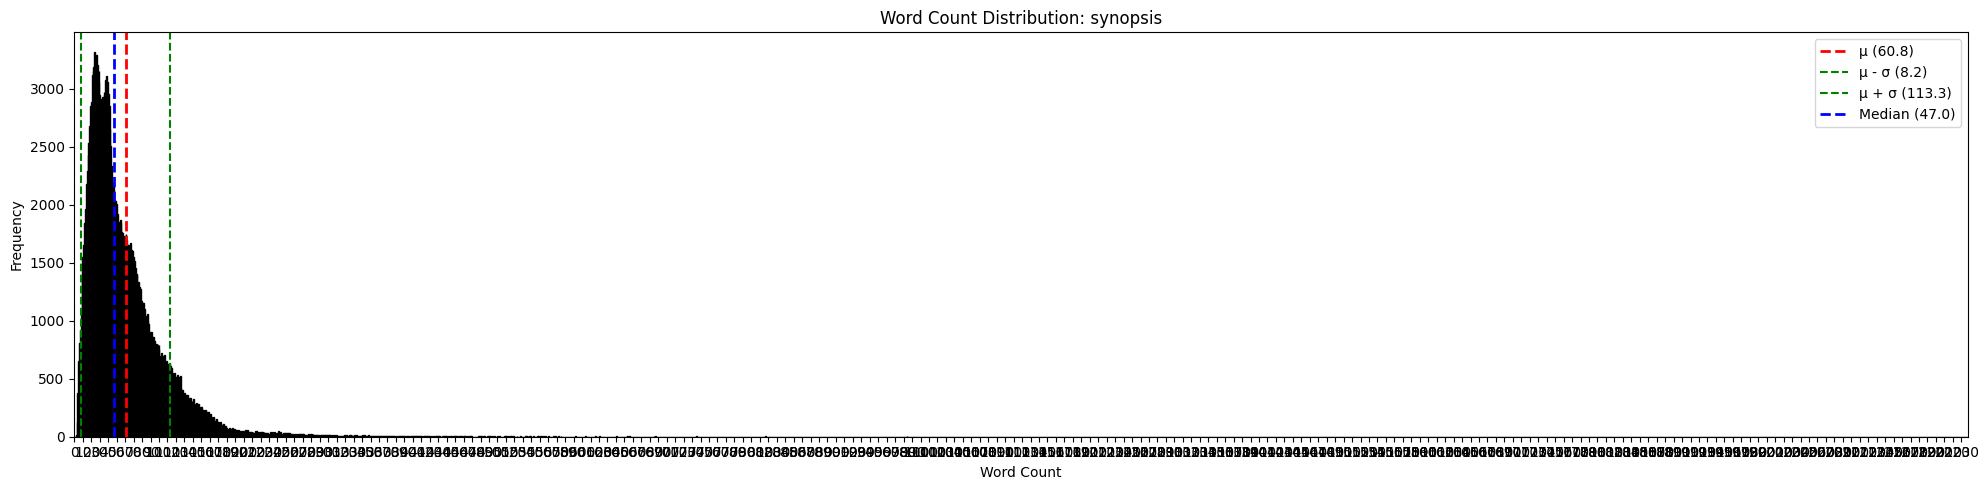


review_texts:
shape: (1, 6)
┌─────┬─────┬──────────┬───────────┬──────────┬────────┐
│ min ┆ max ┆ mean     ┆ std_dev   ┆ total    ┆ median │
│ --- ┆ --- ┆ ---      ┆ ---       ┆ ---      ┆ ---    │
│ i64 ┆ i64 ┆ f64      ┆ f64       ┆ i64      ┆ f64    │
╞═════╪═════╪══════════╪═══════════╪══════════╪════════╡
│ 5   ┆ 669 ┆ 74.48108 ┆ 70.669392 ┆ 15860299 ┆ 50.0   │
└─────┴─────┴──────────┴───────────┴──────────┴────────┘


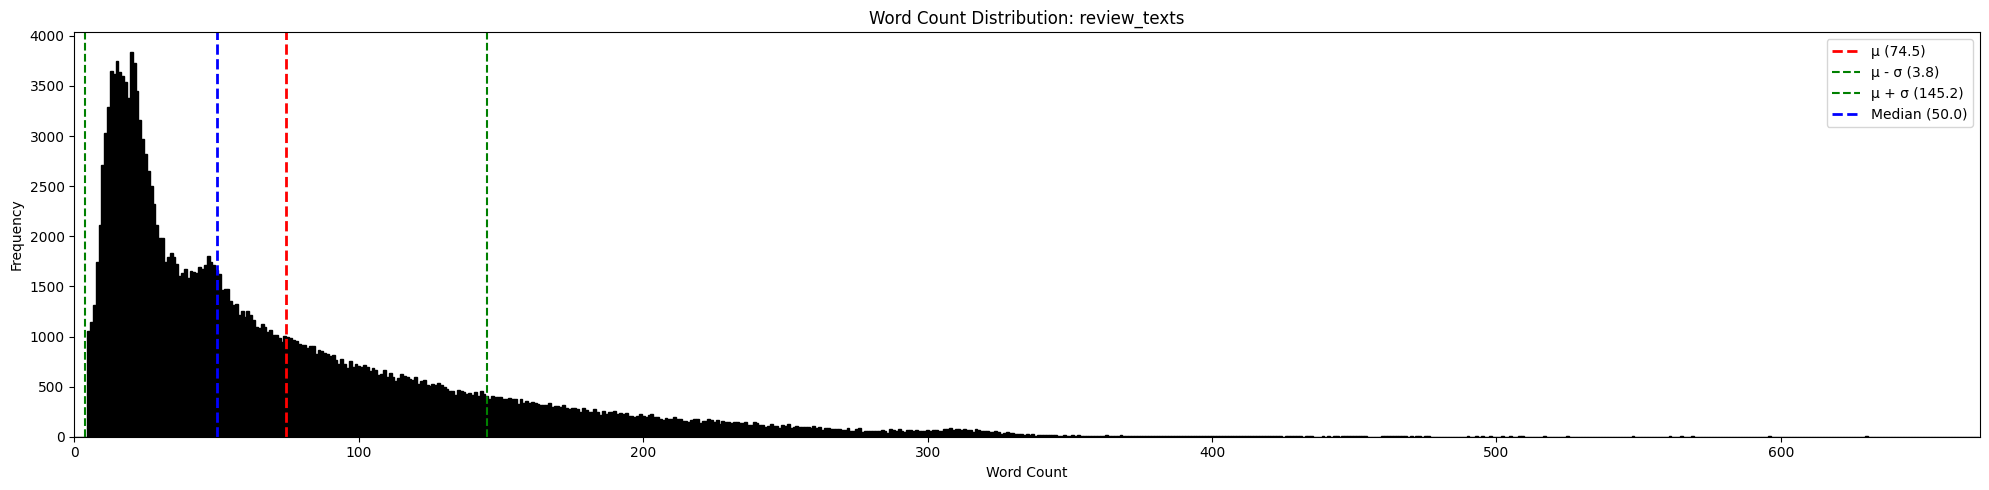

In [13]:
interesting_cols = ["synopsis", "review_texts"]
for col in interesting_cols:
    if col == "review_texts":
        words = df.filter(pl.col(col).is_not_null()).select(
            pl.col(col)
            .list.eval(pl.element().str.split(" "))
            .map_elements(lambda x: sum(len(s) for s in x), return_dtype=pl.Int64)
            .alias("word_count")
        )
        ticks = 100
    else:
        words = df.filter(pl.col(col).is_not_null()).select(pl.col(col).str.split(" ").list.len().alias("word_count"))
        ticks = 10

    stats = words.select(
        pl.col("word_count").min().alias("min"),
        pl.col("word_count").max().alias("max"),
        pl.col("word_count").mean().alias("mean"),
        pl.col("word_count").std().alias("std_dev"),
        pl.col("word_count").sum().alias("total"),
        pl.col("word_count").quantile(0.5).alias("median"),
    )

    print(f"\n{col}:")
    print(stats)

    word_counts = np.array(words["word_count"].to_list())
    mean_val = stats["mean"][0]
    std_val = stats["std_dev"][0]
    median_val = stats["median"][0]

    bins = np.arange(-0.5, word_counts.max() + 1.5, 1)

    plt.figure(figsize=(20, 5))
    plt.hist(word_counts, bins=bins, color="black", edgecolor="black")
    plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"µ ({mean_val:.1f})")
    plt.axvline(
        mean_val - std_val, color="green", linestyle="--", linewidth=1.5, label=f"µ - σ ({mean_val - std_val:.1f})"
    )
    plt.axvline(
        mean_val + std_val, color="green", linestyle="--", linewidth=1.5, label=f"µ + σ ({mean_val + std_val:.1f})"
    )
    plt.axvline(median_val, color="blue", linestyle="--", linewidth=2, label=f"Median ({median_val:.1f})")
    plt.xticks(np.arange(0, word_counts.max() + 1, ticks))
    plt.xlim(0, word_counts.max() + 1)
    plt.title("Word Count Distribution: " + col)
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.legend()
    plt.show()

In [14]:
import collections
from lingua import Language, LanguageDetectorBuilder
from src.data.data_pre_filter import count_emojis, misspelled_ratio

detector = (
    LanguageDetectorBuilder.from_languages(
        Language.ENGLISH,
        Language.SPANISH,
        Language.FRENCH,
        Language.GERMAN,
        Language.PORTUGUESE,
        Language.ITALIAN,
        Language.DUTCH,
        Language.SWEDISH,
        Language.POLISH,
        Language.RUSSIAN,
        Language.JAPANESE,
        Language.KOREAN,
        Language.CHINESE,
    )
    .with_preloaded_language_models()
    .build()
)

all_reviews = df.select(pl.col("review_texts")).explode("review_texts").drop_nulls().to_series().to_list()

emoji_counts = [count_emojis(r) for r in all_reviews]
# non_latin_counts = [count_non_latin_script_chars(r) for r in all_reviews]
# weird_counts = [count_weird_chars(r) for r in all_reviews]
misspelled_ratios = [misspelled_ratio(r) for r in all_reviews]

detected_lang = []
for r in all_reviews:
    try:
        lang = detector.detect_language_of(r)
        if lang is None:
            detected_lang.append("UNKNOWN")
        else:
            detected_lang.append(lang.name)
    except Exception as e:
        print(e)
        detected_lang.append("UNKNOWN")

lang_counts = collections.Counter(detected_lang)

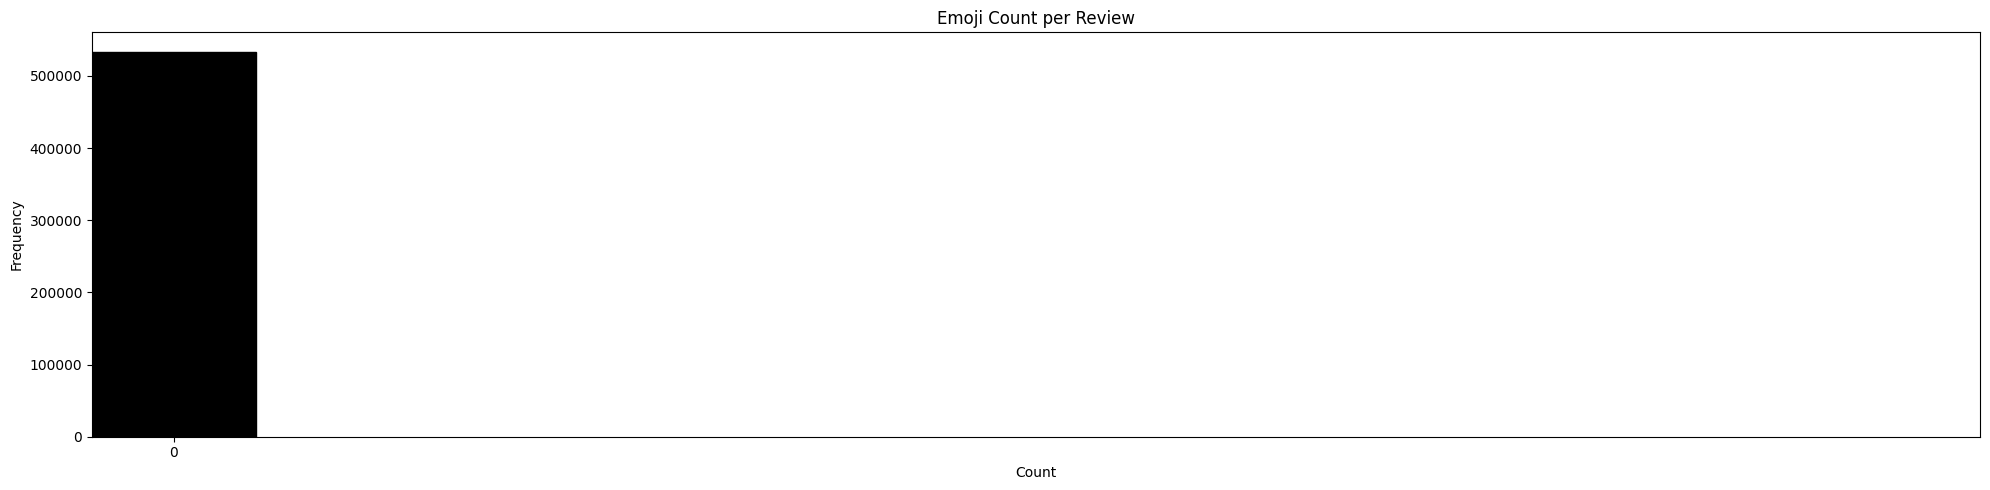

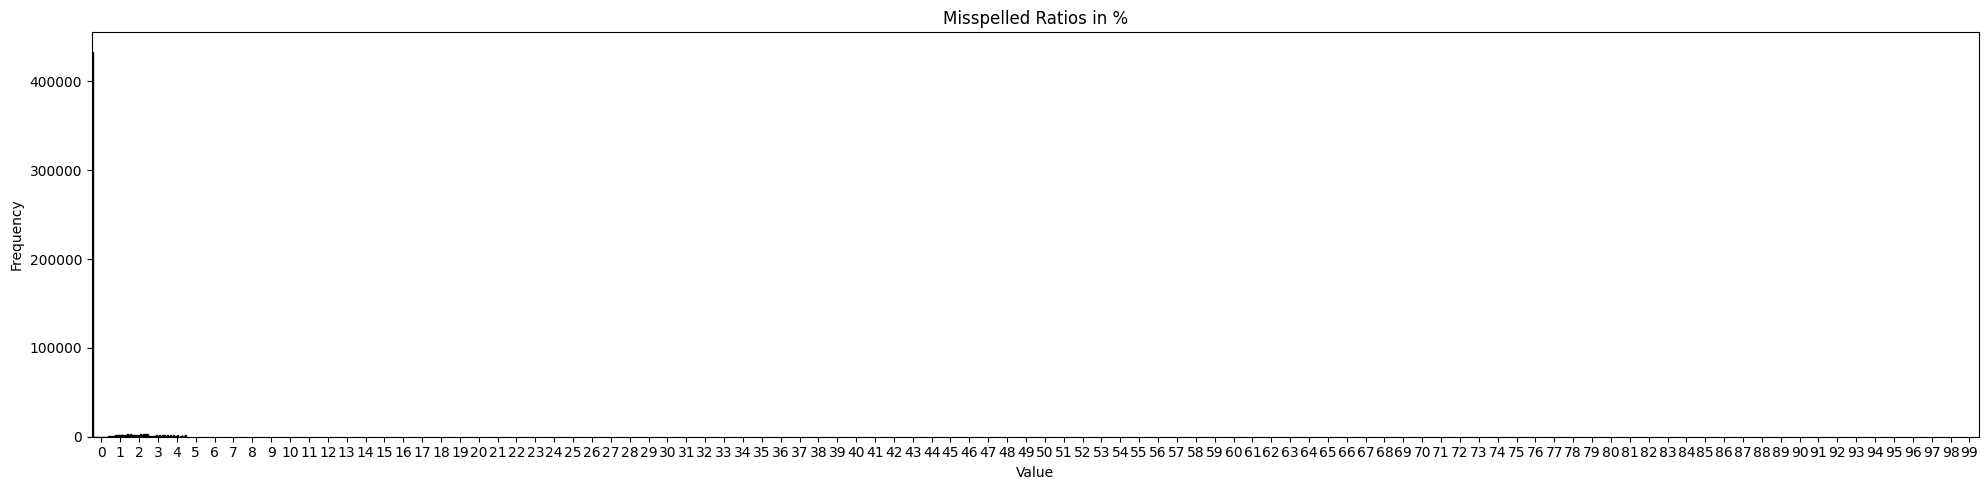

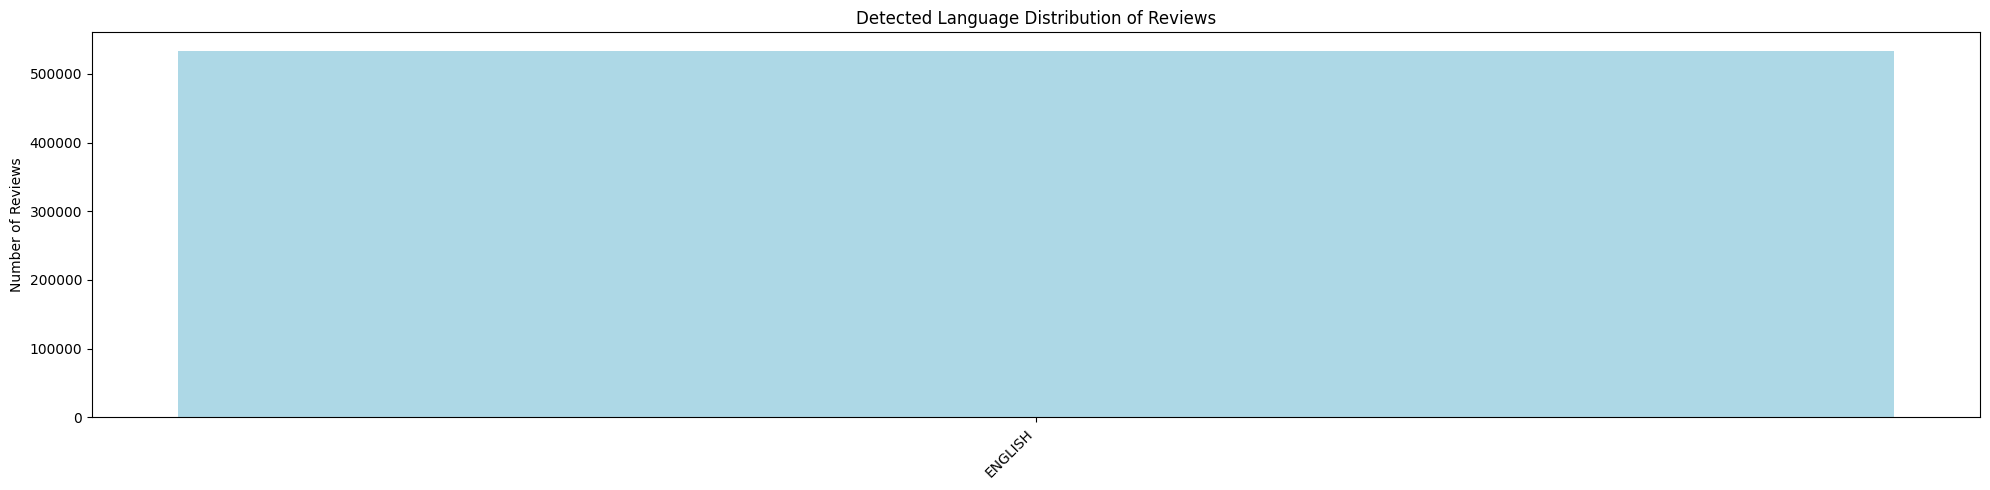

In [15]:
def plot_integer_hist(values, title, tick_step=1, xlim_max=None):
    values = np.array(values)
    min_v = values.min()
    max_v = values.max()
    bins = np.arange(min_v - 0.5, max_v + 1.5, 1)

    plt.figure(figsize=(20, 5))
    plt.hist(values, bins=bins, color="black", edgecolor="black")

    plt.xticks(np.arange(0, max_v + 1, tick_step))
    if xlim_max:
        plt.xlim(-0.5, xlim_max + 1)
    else:
        plt.xlim(-0.5, max_v + 1)
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


plot_integer_hist(emoji_counts, "Emoji Count per Review", tick_step=1, xlim_max=10)
# plot_integer_hist(non_latin_counts, "Non-Latin Characters per Review", tick_step=100)
# plot_integer_hist(weird_counts, "Weird Characters (So/Mn/Cf/Co) per Review", tick_step=10)

misspelled_ratios = np.asarray(misspelled_ratios, dtype=float)
bins = 100

plt.figure(figsize=(20, 5))
plt.hist(misspelled_ratios, bins=bins, color="black", edgecolor="black")

tick_step = 0.01
ticks = np.arange(-tick_step / 2, tick_step / 2 + 1, tick_step)
tick_labels = [f"{int(t * 100)}" for t in ticks]
plt.xticks(ticks, tick_labels)

plt.xlim(0, 1)
plt.title("Misspelled Ratios in %")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 5))
plt.bar(lang_counts.keys(), lang_counts.values(), color="lightblue")
plt.title("Detected Language Distribution of Reviews")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [16]:
short_review = df.filter(
    pl.col("review_texts").is_not_null()
    & (pl.col("review_texts").list.eval(pl.element().str.split(" ").list.len()).list.sum() <= 5)
).select(["title", "synopsis", "review_texts"])

print(f"Movies with short review: {len(short_review)}")
for row in short_review.head(30).iter_rows(named=True):
    print(f"\nTitle: {row['title']}")
    print(f"Review: {row['review_texts']}")
    print("-" * 80)

Movies with short review: 1054

Title: Once Upon a Time in Anatolia
Review: ['A truly remarkable cinematic experience.']
--------------------------------------------------------------------------------

Title: The Real Sopranos
Review: ["I think it's high time."]
--------------------------------------------------------------------------------

Title: Pretty Little Liars: A-List Wrap Party
Review: ['This film was absolutely terrible.']
--------------------------------------------------------------------------------

Title: Fightmarker's Rap Battles: Deadpool vs Peter Griffin
Review: ['This is a fantastic film!']
--------------------------------------------------------------------------------

Title: A Literal Haunting
Review: ["It's a really enjoyable film!"]
--------------------------------------------------------------------------------

Title: 1-800-ALL-GOOD
Review: ['This film is incredibly frustrating.']
------------------------------------------------------------------------------

In [17]:
from src.utils.data_loader import read_file_only_reviews

# file_path = "../../data/letterboxd_filtered_llm.jsonl"
text = read_file_only_reviews(file_path)
sorted_by_length = sorted(enumerate(text), key=lambda x: len(x[1].split()), reverse=True)

print("Top 10 längste Reviews:")
print("=" * 60)

for i, (idx, review) in enumerate(sorted_by_length[:10], 1):
    word_count = len(review.split())
    print(f"\n{i}. Index {idx} ({word_count} Wörter):")
    print(f"{review}")

Number of reviews: 533.625
Top 10 längste Reviews:

1. Index 95378 (167 Wörter):
Ga-Ra-Ku-Ta: Mr. Stain on Junk Alley is surprisingly underrated, probably one of the least recognized works by Ryuji Masuda alongside Popee the Performer and Funny Pets. It's incredibly strange; don't get me wrong. It has themes of death, suicide, and violence. Keep in mind that this show is made for a very young audience. What separates it from others is that it actually has a bit of heart. The characters help each other through their difficult living situation, and Stain and Palvan are shown to have empathy; they lose this empathy when the situation calls for it. The slapstick may seem jarring to the average viewer, but I personally found it really funny! Another thing to note is the style. Since this show was created by Popee the Performer, it's harmonica episode is one of the funniest no-dialogue animations I've ever seen. It's like Tom and Jerry on drugs; except it's not, because there's solid charact

In [18]:
import random
from src.utils.data_loader import read_file_only_reviews

text = read_file_only_reviews(file_path)
n = 20
random_indices = random.sample(range(len(text)), n)

print(f"{n} zufällige Reviews:")
print("=" * 60)

for i, idx in enumerate(random_indices, 1):
    review = text[idx]
    word_count = len(review.split())
    print(f"\n{i}. Index {idx} ({word_count} Wörter):")
    print(review)

Number of reviews: 533.625
20 zufällige Reviews:

1. Index 145561 (22 Wörter):
Mike Leigh just knows how to write a mean and lean screenplay, delivering more than some films can achieve in 90 minutes.

2. Index 449373 (19 Wörter):
Slow starter, but sweet smooth finish. Should have been filmed on location in Mt Airy, but obviously was not.

3. Index 438336 (43 Wörter):
This movie defies expectations as a horror film, instead opting for a low-key slasher with some old-fashioned elements. While the atmosphere is chill and likable actors make it somewhat palatable, the film relies too heavily on familiar tropes and eventually falters in interest.

4. Index 124849 (90 Wörter):
There is small amount of footage of Moby Dick, and it may have been meant for TV and be just an idea, but it is the most modern film that I've seen. Highest; at the top of what cinema can do. As he himself put it: a new kind of film. With highest impact of Melville's text, I believe. Full of impression, it is physical